# AIRBNB NYC PRICING OPTIMIZATION - MASTER NOTEBOOK

This notebook contains the complete workflow for your project.
Run cells in order from top to bottom.

Team: Princy Doshi, Ashutosh Agrawal, Om Thakur
Course: Data Science and AI for Business
Professor: Dr. Chris Volinsky

Dataset: Inside Airbnb NYC - listings.csv.gz
Source: http://insideairbnb.com/get-the-data/

# SECTION 0: SETUP AND IMPORTS

In [1]:
print("Installing/importing required packages...")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All packages loaded successfully!")
print("="*80)
print("AIRBNB PRICING OPTIMIZATION - MASTER NOTEBOOK")
print("="*80)

Installing/importing required packages...
✅ All packages loaded successfully!
AIRBNB PRICING OPTIMIZATION - MASTER NOTEBOOK


# SECTION 1: LOAD AND EXPLORE DATA

In [2]:
print("\n" + "="*80)
print("SECTION 1: DATA LOADING")
print("="*80)

# Load the data
# Make sure listings.csv.gz is in the same folder as this notebook!
filepath = '/Users/theomthakur/Documents/NYU/Semester 3/Data Science and AI for Business/Project/data/listings.csv.gz'

try:
    df = pd.read_csv(filepath, compression='gzip')
    print(f"✅ Data loaded successfully!")
    print(f"   Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
except FileNotFoundError:
    print(f"❌ ERROR: Could not find {filepath}")
    print("   Please download 'listings.csv.gz' from http://insideairbnb.com/get-the-data/")
    print("   And place it in the same folder as this notebook.")
    raise

# Quick look at the data
print("\n📊 First few rows:")
print(df.head())

print("\n📋 Available columns:")
print(df.columns.tolist())


SECTION 1: DATA LOADING
✅ Data loaded successfully!
   Shape: 36,111 rows × 79 columns

📊 First few rows:
         id                            listing_url       scrape_id last_scraped           source                                         name                                        description                              neighborhood_overview                                        picture_url    host_id                                     host_url host_name  host_since            host_location                                         host_about  host_response_time host_response_rate host_acceptance_rate host_is_superhost                                 host_thumbnail_url                                   host_picture_url host_neighbourhood  host_listings_count  host_total_listings_count  host_verifications  ... availability_365 calendar_last_scraped number_of_reviews number_of_reviews_ltm number_of_reviews_l30d  availability_eoy  number_of_reviews_ly estimated_occupancy_l365d esti

# SECTION 2: INITIAL EXPLORATION - UNDERSTAND NEIGHBORHOODS


SECTION 2: NEIGHBORHOOD EXPLORATION
Using neighborhood column: 'neighbourhood_cleansed'

📍 Top 15 Neighborhoods:
                        listing_count  avg_price  median_price  avg_reviews
neighbourhood_cleansed                                                     
Bedford-Stuyvesant               2612     145.65         117.0        35.19
Williamsburg                     2049     791.91         165.0        21.75
Midtown                          1993    2360.96         367.0        19.90
Harlem                           1685     178.48         115.0        33.94
Hell's Kitchen                   1496    1567.96         217.5        21.84
Upper West Side                  1458    1886.68         216.0        14.80
Bushwick                         1443     121.20          86.5        21.86
Upper East Side                  1399    1141.95         209.5        11.48
Crown Heights                    1133     203.50         127.5        29.93
East Village                      959     276.60  

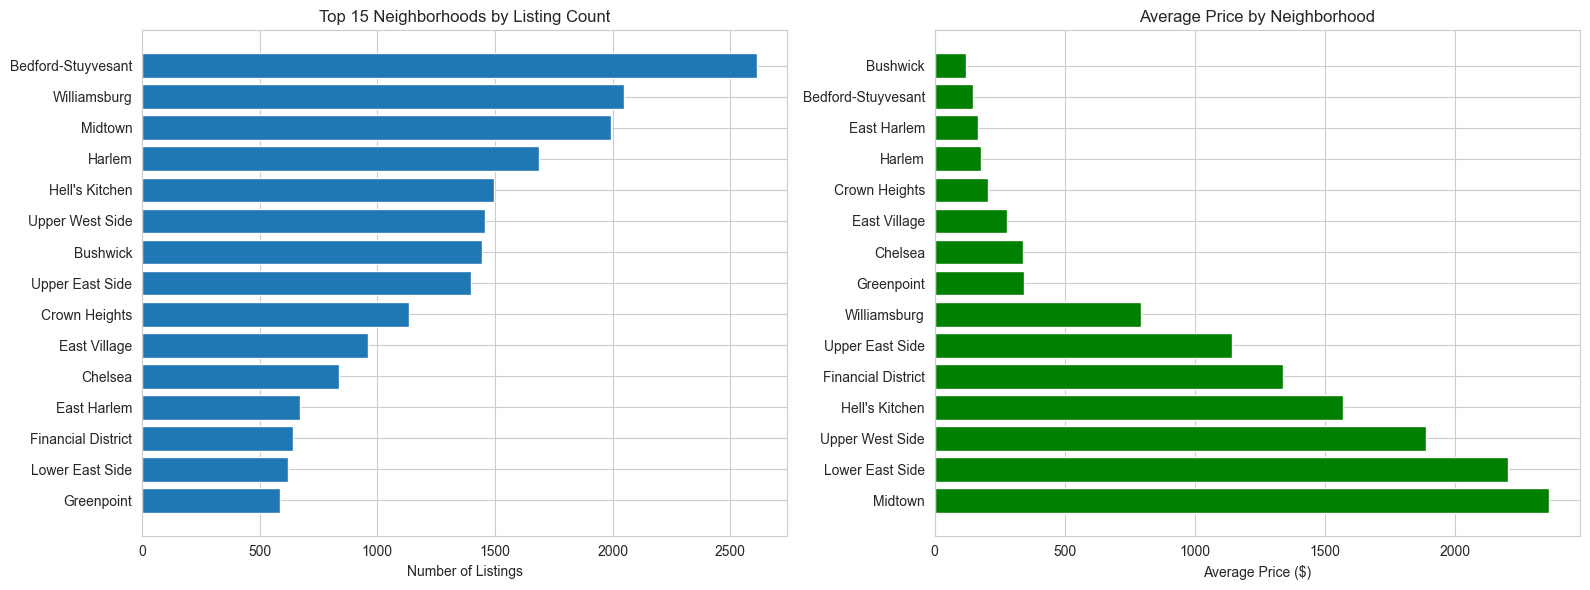


✅ Visualization saved as 'neighborhood_overview.png'


In [3]:
print("\n" + "="*80)
print("SECTION 2: NEIGHBORHOOD EXPLORATION")
print("="*80)

# Identify neighborhood column
if 'neighbourhood_cleansed' in df.columns:
    neighborhood_col = 'neighbourhood_cleansed'
elif 'neighbourhood' in df.columns:
    neighborhood_col = 'neighbourhood'
else:
    raise ValueError("No neighborhood column found!")

print(f"Using neighborhood column: '{neighborhood_col}'")

# Clean price for analysis
if df['price'].dtype == 'object':
    df['price_clean'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
else:
    df['price_clean'] = df['price']

# Neighborhood statistics
neighborhood_stats = df.groupby(neighborhood_col).agg({
    'id': 'count',
    'price_clean': ['mean', 'median'],
    'number_of_reviews': 'mean'
}).round(2)

neighborhood_stats.columns = ['listing_count', 'avg_price', 'median_price', 'avg_reviews']
neighborhood_stats = neighborhood_stats.sort_values('listing_count', ascending=False)

print(f"\n📍 Top 15 Neighborhoods:")
print(neighborhood_stats.head(15))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Listing count
top_15 = neighborhood_stats.head(15)
axes[0].barh(range(len(top_15)), top_15['listing_count'])
axes[0].set_yticks(range(len(top_15)))
axes[0].set_yticklabels(top_15.index)
axes[0].set_xlabel('Number of Listings')
axes[0].set_title('Top 15 Neighborhoods by Listing Count')
axes[0].invert_yaxis()

# Average price
top_15_price = top_15.sort_values('avg_price')
axes[1].barh(range(len(top_15_price)), top_15_price['avg_price'], color='green')
axes[1].set_yticks(range(len(top_15_price)))
axes[1].set_yticklabels(top_15_price.index)
axes[1].set_xlabel('Average Price ($)')
axes[1].set_title('Average Price by Neighborhood')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('neighborhood_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualization saved as 'neighborhood_overview.png'")

# SECTION 3: CHOOSE YOUR NEIGHBORHOODS AND FILTER DATA

In [4]:
print("\n" + "="*80)
print("SECTION 3: DATA FILTERING AND SCOPING")
print("="*80)

# 🎯 IMPORTANT: UPDATE THESE WITH YOUR CHOSEN NEIGHBORHOODS!
# Look at the output above and pick 2-3 neighborhoods with:
# - Different price points (high, mid, low)
# - Sufficient data (at least 200-300 listings each)

TARGET_NEIGHBORHOODS = [
    'Williamsburg',           # Brooklyn - trendy
    'Upper East Side',        # Manhattan - UES
    'Astoria',               # Queens - budget
    'Bedford-Stuyvesant',    # Brooklyn - emerging
    'Hell\'s Kitchen',       # Manhattan - Midtown
    'Harlem',                # Manhattan - diverse
    'Bushwick',              # Brooklyn - hipster
    'Crown Heights',         # Brooklyn - residential
]

print(f"🎯 Selected neighborhoods: {TARGET_NEIGHBORHOODS}")

# Filter to chosen neighborhoods
df_filtered = df[df[neighborhood_col].isin(TARGET_NEIGHBORHOODS)].copy()
print(f"\n   Original dataset: {len(df):,} listings")
print(f"   After neighborhood filter: {len(df_filtered):,} listings")

# Additional filters (as recommended by professor)
print("\n📊 Applying quality filters...")

initial_count = len(df_filtered)

# Filter 1: Room type (entire home/apt only - what property managers care about)
if 'room_type' in df_filtered.columns:
    df_filtered = df_filtered[df_filtered['room_type'] == 'Entire home/apt']
    print(f"   After 'Entire home/apt' filter: {len(df_filtered):,} listings")

# Filter 2: Minimum reviews (established listings only)
MIN_REVIEWS = 5
if 'number_of_reviews' in df_filtered.columns:
    df_filtered = df_filtered[df_filtered['number_of_reviews'] >= MIN_REVIEWS]
    print(f"   After minimum {MIN_REVIEWS} reviews filter: {len(df_filtered):,} listings")

# Filter 3: Availability (active listings)
MIN_AVAILABILITY = 15
if 'availability_365' in df_filtered.columns:
    df_filtered = df_filtered[df_filtered['availability_365'] >= MIN_AVAILABILITY]
    print(f"   After minimum {MIN_AVAILABILITY} days available: {len(df_filtered):,} listings")

# Filter 4: Price range (remove outliers)
PRICE_MIN = 50
PRICE_MAX = 1000
df_filtered = df_filtered[(df_filtered['price_clean'] >= PRICE_MIN) & 
                          (df_filtered['price_clean'] <= PRICE_MAX)]
print(f"   After price range ${PRICE_MIN}-${PRICE_MAX}: {len(df_filtered):,} listings")

print(f"\n✅ Final dataset: {len(df_filtered):,} listings ({100*len(df_filtered)/initial_count:.1f}% retained)")

if len(df_filtered) < 500:
    print(f"\n⚠️  WARNING: Only {len(df_filtered)} listings remaining.")
    print("   Consider relaxing filters or choosing different neighborhoods.")



SECTION 3: DATA FILTERING AND SCOPING
🎯 Selected neighborhoods: ['Williamsburg', 'Upper East Side', 'Astoria', 'Bedford-Stuyvesant', "Hell's Kitchen", 'Harlem', 'Bushwick', 'Crown Heights']

   Original dataset: 36,111 listings
   After neighborhood filter: 12,364 listings

📊 Applying quality filters...
   After 'Entire home/apt' filter: 6,178 listings
   After minimum 5 reviews filter: 3,120 listings
   After minimum 15 days available: 2,084 listings
   After price range $50-$1000: 1,937 listings

✅ Final dataset: 1,937 listings (15.7% retained)


# SECTION 4: DATA CLEANING

In [5]:
print("\n" + "="*80)
print("SECTION 4: DATA CLEANING")
print("="*80)

df_clean = df_filtered.copy()

# Handle price column
df_clean['price'] = df_clean['price_clean']

# Drop rows with missing critical columns
critical_cols = ['price', 'latitude', 'longitude']
before_drop = len(df_clean)
df_clean = df_clean.dropna(subset=critical_cols)
print(f"Dropped {before_drop - len(df_clean)} rows with missing critical data")

# Handle bathrooms (might be text like "2.5 baths")
if 'bathrooms_text' in df_clean.columns and 'bathrooms' not in df_clean.columns:
    # Extract numeric value
    df_clean['bathrooms'] = df_clean['bathrooms_text'].str.extract('(\d+\.?\d*)').astype(float)
    print("Extracted numeric bathrooms from bathrooms_text")

# Fill missing numeric columns with median
numeric_cols = ['accommodates', 'bedrooms', 'beds', 'bathrooms', 
                'number_of_reviews', 'reviews_per_month', 'availability_365',
                'minimum_nights']

for col in numeric_cols:
    if col in df_clean.columns:
        if df_clean[col].isnull().sum() > 0:
            median_val = df_clean[col].median()
            df_clean[col].fillna(median_val, inplace=True)
            print(f"   Filled {col} missing values with median: {median_val:.2f}")

# Handle bedrooms = 0 (studio apartments)
if 'bedrooms' in df_clean.columns:
    df_clean['bedrooms'].fillna(0, inplace=True)

print(f"\n✅ Cleaned dataset shape: {df_clean.shape}")


SECTION 4: DATA CLEANING
Dropped 0 rows with missing critical data
   Filled bedrooms missing values with median: 1.00
   Filled beds missing values with median: 2.00

✅ Cleaned dataset shape: (1937, 80)


# SECTION 5: FEATURE ENGINEERING

In [6]:
print("\n" + "="*80)
print("SECTION 5: FEATURE ENGINEERING")
print("="*80)

# Feature 1: Occupancy proxy
if 'availability_365' in df_clean.columns:
    df_clean['occupancy_proxy'] = 365 - df_clean['availability_365']
    df_clean['occupancy_rate'] = df_clean['occupancy_proxy'] / 365
    print("✅ Created: occupancy_proxy, occupancy_rate")

# Feature 2: Review intensity (annualized)
if 'reviews_per_month' in df_clean.columns:
    df_clean['review_intensity'] = df_clean['reviews_per_month'] * 12
    print("✅ Created: review_intensity")

# Feature 3: Instant bookable (convert t/f to 1/0)
if 'instant_bookable' in df_clean.columns:
    df_clean['instant_bookable_num'] = (df_clean['instant_bookable'] == 't').astype(int)
    print("✅ Created: instant_bookable_num")

# Feature 4: Superhost status
if 'host_is_superhost' in df_clean.columns:
    df_clean['is_superhost'] = (df_clean['host_is_superhost'] == 't').astype(int)
    print("✅ Created: is_superhost")

# Feature 5: Average review score (composite)
review_score_cols = [col for col in df_clean.columns if 'review_scores' in col.lower()]
if review_score_cols:
    df_clean['avg_review_score'] = df_clean[review_score_cols].mean(axis=1)
    print(f"✅ Created: avg_review_score (from {len(review_score_cols)} columns)")

# Feature 6: Amenities count
if 'amenities' in df_clean.columns:
    df_clean['amenities_count'] = df_clean['amenities'].str.count(',') + 1
    df_clean['amenities_count'].fillna(0, inplace=True)
    print("✅ Created: amenities_count")

# Feature 7: Host experience (days since first review)
if 'first_review' in df_clean.columns:
    df_clean['first_review_date'] = pd.to_datetime(df_clean['first_review'], errors='coerce')
    df_clean['days_as_host'] = (pd.Timestamp.now() - df_clean['first_review_date']).dt.days
    df_clean['days_as_host'].fillna(0, inplace=True)
    print("✅ Created: days_as_host")

print(f"\n✅ Feature engineering complete. Total features: {df_clean.shape[1]}")


SECTION 5: FEATURE ENGINEERING
✅ Created: occupancy_proxy, occupancy_rate
✅ Created: review_intensity
✅ Created: instant_bookable_num
✅ Created: is_superhost
✅ Created: avg_review_score (from 7 columns)
✅ Created: amenities_count
✅ Created: days_as_host

✅ Feature engineering complete. Total features: 89


# SECTION 6: EXPLORATORY DATA ANALYSIS


SECTION 6: EXPLORATORY DATA ANALYSIS


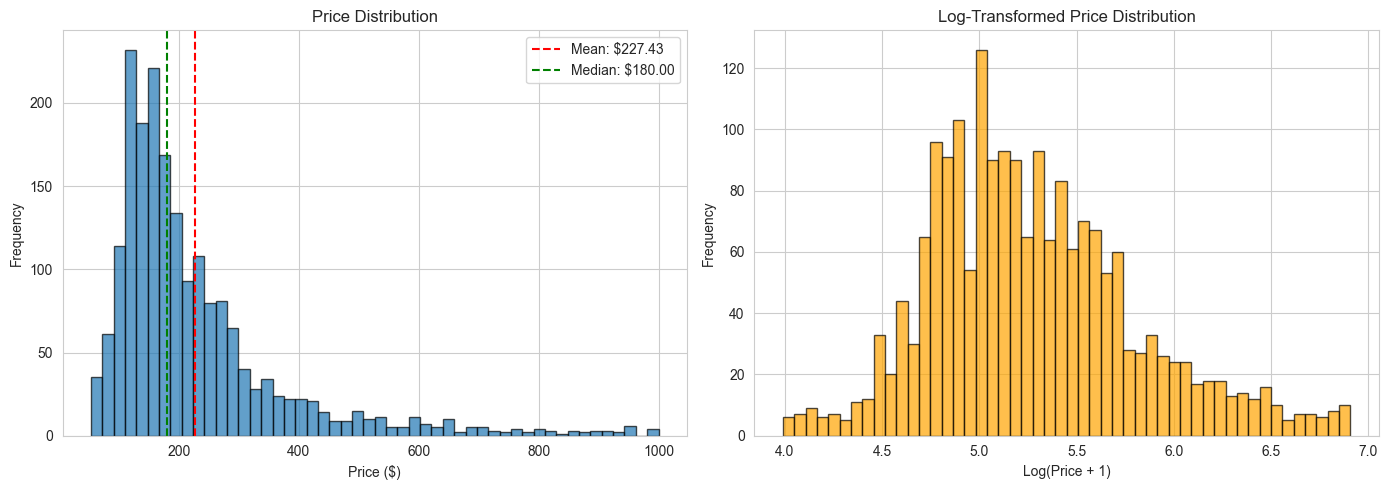


💰 Price Statistics:
   Mean: $227.43
   Median: $180.00
   Std Dev: $151.90
   Min: $53.00
   Max: $1000.00


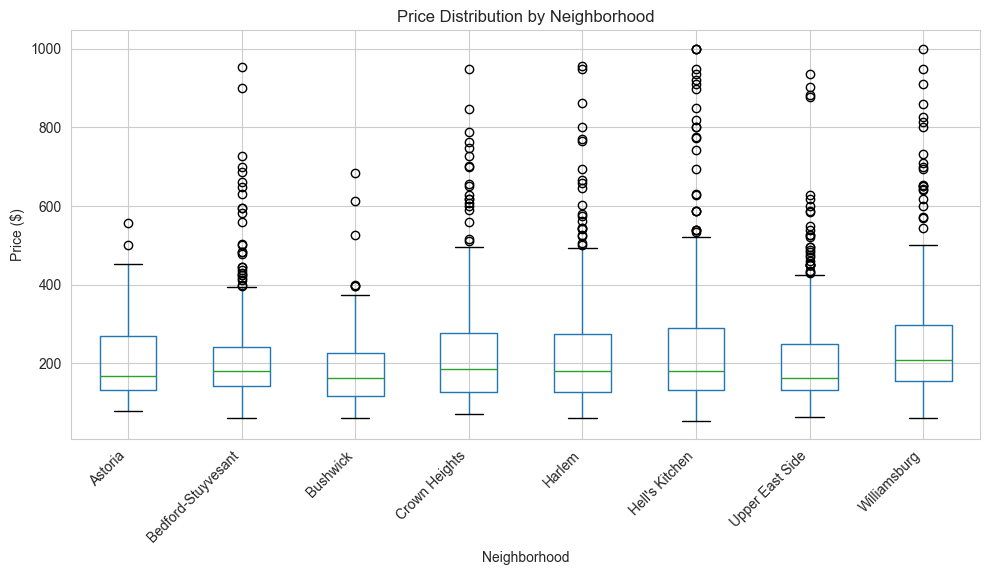


📍 Price by Neighborhood:
   Williamsburg:
      Mean: $258.82
      Median: $208.00
      Count: 261
   Upper East Side:
      Mean: $217.90
      Median: $162.00
      Count: 319
   Astoria:
      Mean: $204.46
      Median: $167.00
      Count: 65
   Bedford-Stuyvesant:
      Mean: $211.41
      Median: $180.00
      Count: 394
   Hell's Kitchen:
      Mean: $252.59
      Median: $180.00
      Count: 259
   Harlem:
      Mean: $227.30
      Median: $180.00
      Count: 279
   Bushwick:
      Mean: $186.23
      Median: $163.00
      Count: 132
   Crown Heights:
      Mean: $234.49
      Median: $184.50
      Count: 228


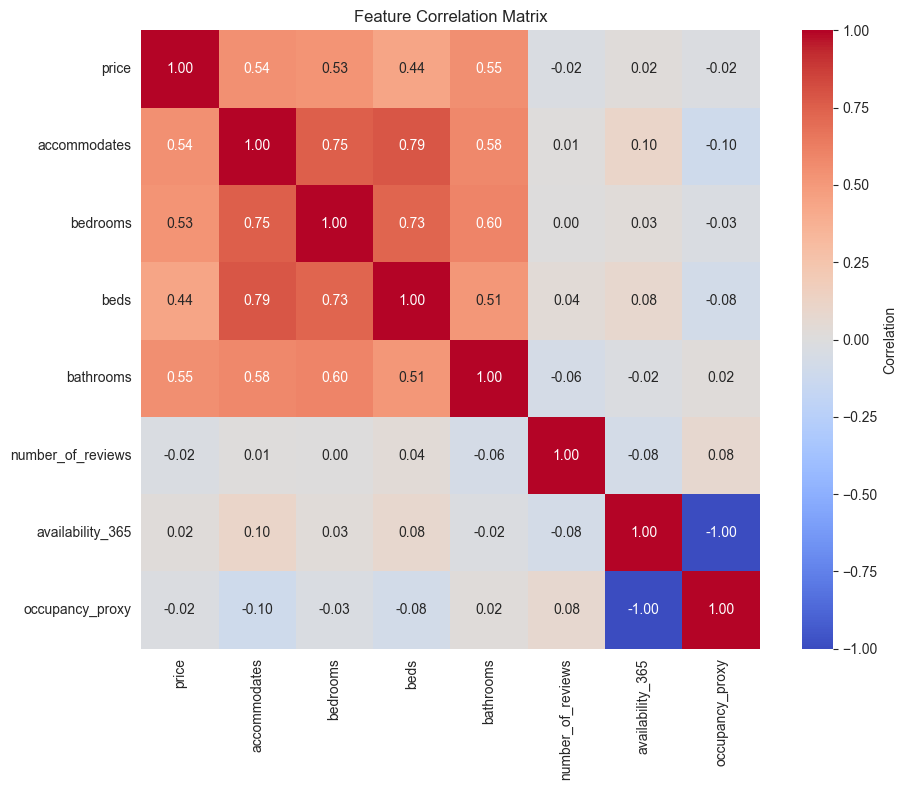


🔗 Strongest correlations with price:
   bathrooms                  0.547
   accommodates               0.542
   bedrooms                   0.526
   beds                       0.438
   availability_365           0.018
   occupancy_proxy           -0.018
   number_of_reviews         -0.025


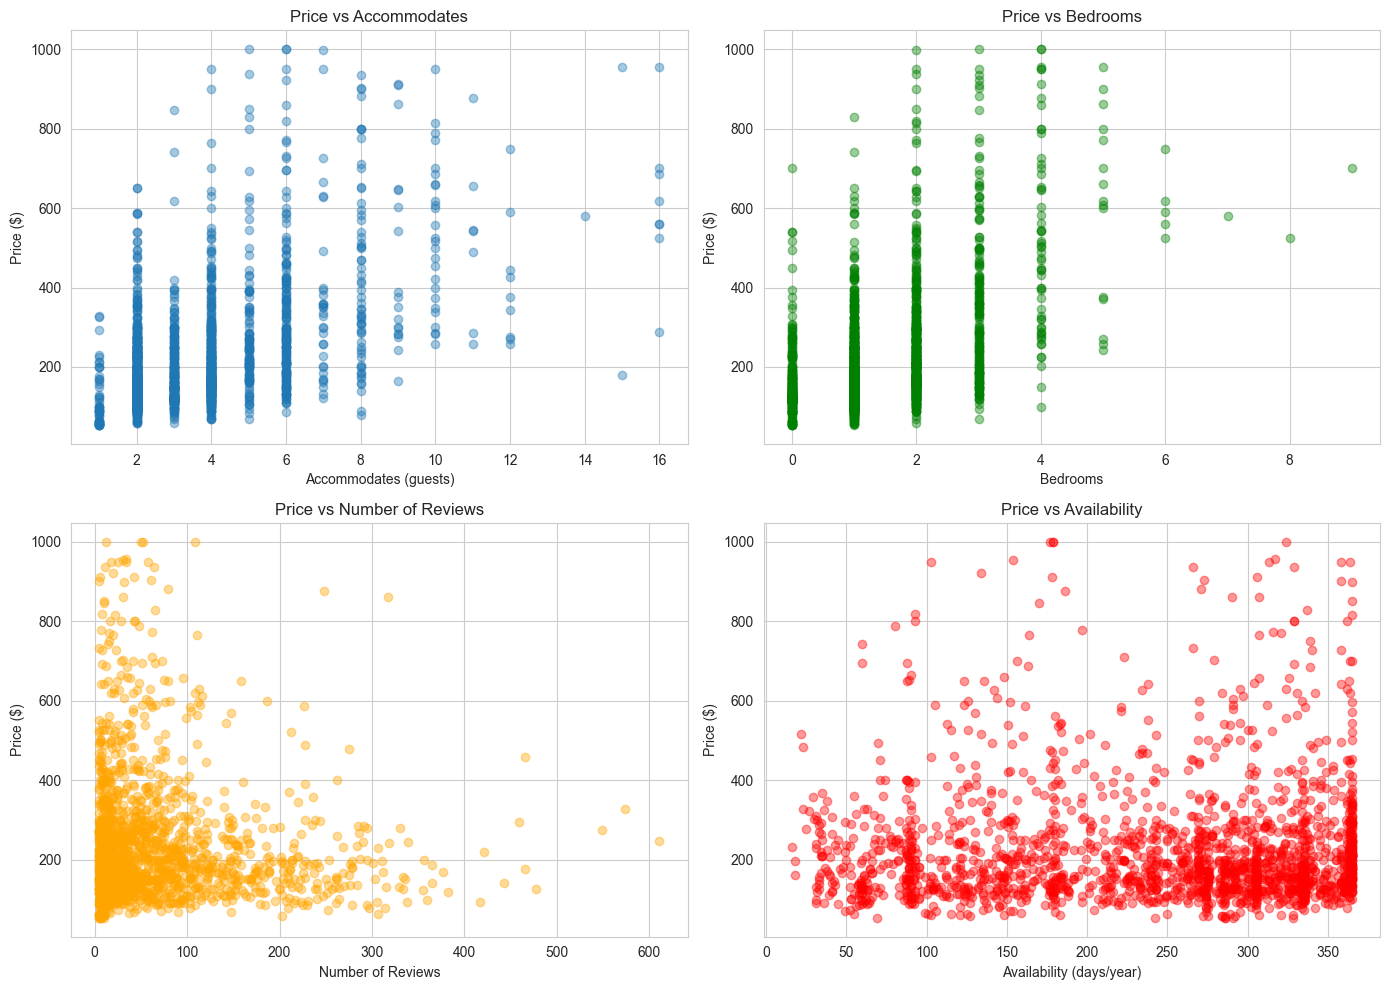


✅ All EDA visualizations saved!


In [7]:
print("\n" + "="*80)
print("SECTION 6: EXPLORATORY DATA ANALYSIS")
print("="*80)

# EDA 1: Price distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df_clean['price'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Price ($)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Price Distribution')
axes[0].axvline(df_clean['price'].mean(), color='red', linestyle='--', 
                label=f'Mean: ${df_clean["price"].mean():.2f}')
axes[0].axvline(df_clean['price'].median(), color='green', linestyle='--',
                label=f'Median: ${df_clean["price"].median():.2f}')
axes[0].legend()

axes[1].hist(np.log1p(df_clean['price']), bins=50, edgecolor='black', 
            alpha=0.7, color='orange')
axes[1].set_xlabel('Log(Price + 1)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Log-Transformed Price Distribution')

plt.tight_layout()
plt.savefig('price_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n💰 Price Statistics:")
print(f"   Mean: ${df_clean['price'].mean():.2f}")
print(f"   Median: ${df_clean['price'].median():.2f}")
print(f"   Std Dev: ${df_clean['price'].std():.2f}")
print(f"   Min: ${df_clean['price'].min():.2f}")
print(f"   Max: ${df_clean['price'].max():.2f}")

# EDA 2: Price by neighborhood
plt.figure(figsize=(10, 6))
df_clean.boxplot(column='price', by=neighborhood_col, ax=plt.gca())
plt.xlabel('Neighborhood')
plt.ylabel('Price ($)')
plt.title('Price Distribution by Neighborhood')
plt.suptitle('')  # Remove automatic title
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('price_by_neighborhood_box.png', dpi=300, bbox_inches='tight')
plt.show()

# Print neighborhood price stats
print(f"\n📍 Price by Neighborhood:")
for hood in TARGET_NEIGHBORHOODS:
    hood_data = df_clean[df_clean[neighborhood_col] == hood]
    print(f"   {hood}:")
    print(f"      Mean: ${hood_data['price'].mean():.2f}")
    print(f"      Median: ${hood_data['price'].median():.2f}")
    print(f"      Count: {len(hood_data)}")

# EDA 3: Correlation matrix
key_features = ['price', 'accommodates', 'bedrooms', 'beds', 'bathrooms',
                'number_of_reviews', 'availability_365', 'occupancy_proxy']
key_features = [f for f in key_features if f in df_clean.columns]

plt.figure(figsize=(10, 8))
corr_matrix = df_clean[key_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
           fmt='.2f', square=True, cbar_kws={'label': 'Correlation'})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n🔗 Strongest correlations with price:")
price_corr = corr_matrix['price'].sort_values(ascending=False)
for feature, corr in price_corr.items():
    if feature != 'price':
        print(f"   {feature:<25} {corr:>6.3f}")

# EDA 4: Key scatter plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Accommodates vs Price
axes[0, 0].scatter(df_clean['accommodates'], df_clean['price'], alpha=0.4)
axes[0, 0].set_xlabel('Accommodates (guests)')
axes[0, 0].set_ylabel('Price ($)')
axes[0, 0].set_title('Price vs Accommodates')

# Bedrooms vs Price
if 'bedrooms' in df_clean.columns:
    axes[0, 1].scatter(df_clean['bedrooms'], df_clean['price'], alpha=0.4, color='green')
    axes[0, 1].set_xlabel('Bedrooms')
    axes[0, 1].set_ylabel('Price ($)')
    axes[0, 1].set_title('Price vs Bedrooms')

# Reviews vs Price
axes[1, 0].scatter(df_clean['number_of_reviews'], df_clean['price'], alpha=0.4, color='orange')
axes[1, 0].set_xlabel('Number of Reviews')
axes[1, 0].set_ylabel('Price ($)')
axes[1, 0].set_title('Price vs Number of Reviews')

# Availability vs Price
axes[1, 1].scatter(df_clean['availability_365'], df_clean['price'], alpha=0.4, color='red')
axes[1, 1].set_xlabel('Availability (days/year)')
axes[1, 1].set_ylabel('Price ($)')
axes[1, 1].set_title('Price vs Availability')

plt.tight_layout()
plt.savefig('scatter_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ All EDA visualizations saved!")

# SECTION 7: PREPARE DATA FOR MODELING


In [8]:
print("\n" + "="*80)
print("SECTION 7: PREPARING DATA FOR MODELING")
print("="*80)

# Select features for modeling
feature_columns = [
    'accommodates', 'bedrooms', 'beds', 'bathrooms',
    'number_of_reviews', 'reviews_per_month',
    'availability_365', 'minimum_nights',
    'latitude', 'longitude',
    'occupancy_proxy', 'review_intensity',
    'instant_bookable_num', 'is_superhost',
    'amenities_count'
]

# Keep only features that exist
feature_columns = [col for col in feature_columns if col in df_clean.columns]

print(f"Selected {len(feature_columns)} features:")
for feat in feature_columns:
    print(f"   - {feat}")

# Create feature matrix and target
X = df_clean[feature_columns].copy()
y = df_clean['price'].copy()

# Handle any remaining missing values
X = X.fillna(X.median())

print(f"\n✅ Feature matrix: {X.shape}")
print(f"✅ Target vector: {y.shape}")
print(f"\n💰 Target statistics:")
print(f"   Mean price: ${y.mean():.2f}")
print(f"   Median price: ${y.median():.2f}")
print(f"   Std dev: ${y.std():.2f}")


SECTION 7: PREPARING DATA FOR MODELING
Selected 15 features:
   - accommodates
   - bedrooms
   - beds
   - bathrooms
   - number_of_reviews
   - reviews_per_month
   - availability_365
   - minimum_nights
   - latitude
   - longitude
   - occupancy_proxy
   - review_intensity
   - instant_bookable_num
   - is_superhost
   - amenities_count

✅ Feature matrix: (1937, 15)
✅ Target vector: (1937,)

💰 Target statistics:
   Mean price: $227.43
   Median price: $180.00
   Std dev: $151.90


# SECTION 8: TRAIN-TEST SPLIT

In [9]:
print("\n" + "="*80)
print("SECTION 8: TRAIN-TEST SPLIT")
print("="*80)

# Split data (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")

# Scale features for linear models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Feature scaling complete")



SECTION 8: TRAIN-TEST SPLIT
Training set: 1,549 samples
Test set: 388 samples
✅ Feature scaling complete


# SECTION 9: MODEL TRAINING

In [10]:
print("\n" + "="*80)
print("SECTION 9: MODEL TRAINING AND EVALUATION")
print("="*80)

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=10),
    'Lasso Regression': Lasso(alpha=1),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, 
                                          random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5,
                                                   random_state=42)
}

# Train and evaluate
results = []
trained_models = {}

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {name}...")
    
    # Use scaled data for linear models
    if 'Regression' in name and 'Forest' not in name and 'Boosting' not in name:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    results.append({
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE': mape
    })
    
    trained_models[name] = (model, y_pred)
    
    print(f"   RMSE: ${rmse:.2f}")
    print(f"   MAE: ${mae:.2f}")
    print(f"   R²: {r2:.4f}")
    print(f"   MAPE: {mape:.2f}%")

# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('RMSE')

print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(results_df.to_string(index=False))

# Save results
results_df.to_csv('model_results.csv', index=False)
print("\n✅ Results saved to 'model_results.csv'")


SECTION 9: MODEL TRAINING AND EVALUATION

Training Linear Regression...
   RMSE: $120.97
   MAE: $78.77
   R²: 0.4912
   MAPE: 36.97%

Training Ridge Regression...
   RMSE: $120.98
   MAE: $78.68
   R²: 0.4911
   MAPE: 36.92%

Training Lasso Regression...
   RMSE: $121.03
   MAE: $78.19
   R²: 0.4908
   MAPE: 36.72%

Training Random Forest...
   RMSE: $102.38
   MAE: $65.60
   R²: 0.6356
   MAPE: 29.91%

Training Gradient Boosting...
   RMSE: $100.14
   MAE: $64.20
   R²: 0.6514
   MAPE: 29.68%

MODEL COMPARISON SUMMARY
            Model       RMSE       MAE       R²      MAPE
Gradient Boosting 100.138987 64.195436 0.651356 29.675241
    Random Forest 102.376494 65.595769 0.635601 29.906981
Linear Regression 120.972287 78.770575 0.491199 36.966009
 Ridge Regression 120.981237 78.679322 0.491124 36.918759
 Lasso Regression 121.025472 78.185623 0.490752 36.717343

✅ Results saved to 'model_results.csv'


# SECTION 10: VISUALIZE MODEL PERFORMANCE


SECTION 10: MODEL PERFORMANCE VISUALIZATION


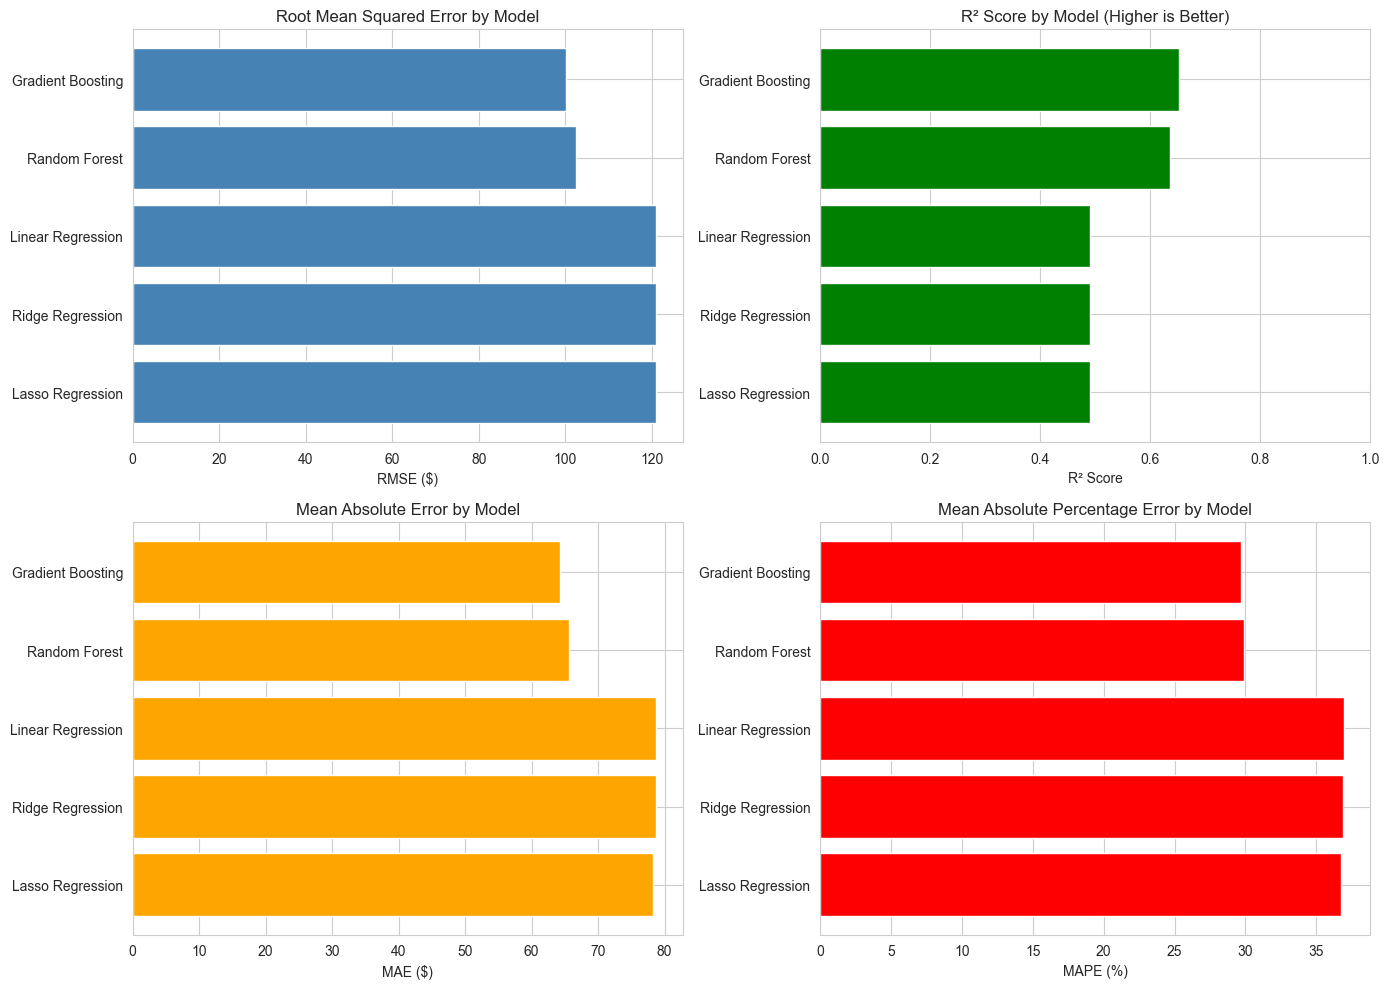

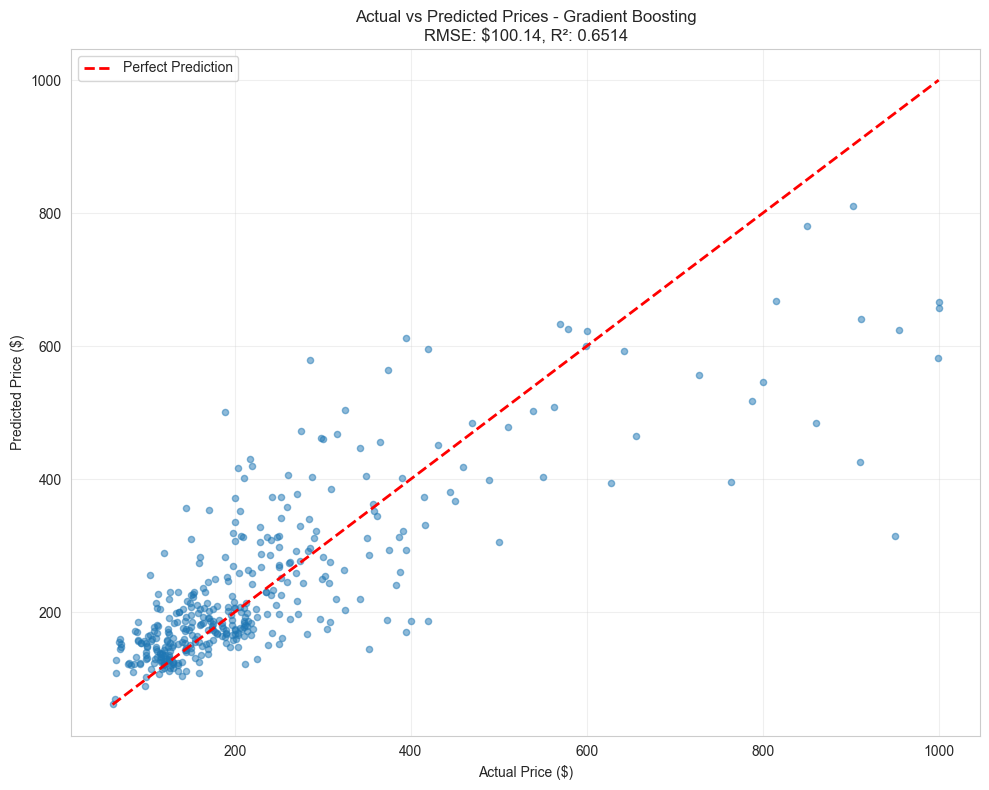


🏆 Best Model: Gradient Boosting
   RMSE: $100.14
   R²: 0.6514


In [11]:
print("\n" + "="*80)
print("SECTION 10: MODEL PERFORMANCE VISUALIZATION")
print("="*80)

# Model comparison charts
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# RMSE
axes[0, 0].barh(results_df['Model'], results_df['RMSE'], color='steelblue')
axes[0, 0].set_xlabel('RMSE ($)')
axes[0, 0].set_title('Root Mean Squared Error by Model')
axes[0, 0].invert_yaxis()

# R²
axes[0, 1].barh(results_df['Model'], results_df['R²'], color='green')
axes[0, 1].set_xlabel('R² Score')
axes[0, 1].set_title('R² Score by Model (Higher is Better)')
axes[0, 1].set_xlim(0, 1)
axes[0, 1].invert_yaxis()

# MAE
axes[1, 0].barh(results_df['Model'], results_df['MAE'], color='orange')
axes[1, 0].set_xlabel('MAE ($)')
axes[1, 0].set_title('Mean Absolute Error by Model')
axes[1, 0].invert_yaxis()

# MAPE
axes[1, 1].barh(results_df['Model'], results_df['MAPE'], color='red')
axes[1, 1].set_xlabel('MAPE (%)')
axes[1, 1].set_title('Mean Absolute Percentage Error by Model')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Best model predictions vs actual
best_model_name = results_df.iloc[0]['Model']
best_model, y_pred_best = trained_models[best_model_name]

plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_best, alpha=0.5, s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title(f'Actual vs Predicted Prices - {best_model_name}\n' + 
          f'RMSE: ${results_df.iloc[0]["RMSE"]:.2f}, R²: {results_df.iloc[0]["R²"]:.4f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   RMSE: ${results_df.iloc[0]['RMSE']:.2f}")
print(f"   R²: {results_df.iloc[0]['R²']:.4f}")

# SECTION 11: FEATURE IMPORTANCE (if tree-based model won)


SECTION 11: FEATURE IMPORTANCE ANALYSIS

Top 15 Most Important Features:
             Feature  Importance
           bathrooms    0.290520
           longitude    0.167177
      minimum_nights    0.127023
        accommodates    0.090550
     amenities_count    0.068308
            latitude    0.063970
            bedrooms    0.061639
   number_of_reviews    0.028671
     occupancy_proxy    0.027660
    availability_365    0.026618
                beds    0.016271
    review_intensity    0.015282
   reviews_per_month    0.008564
        is_superhost    0.005557
instant_bookable_num    0.002191


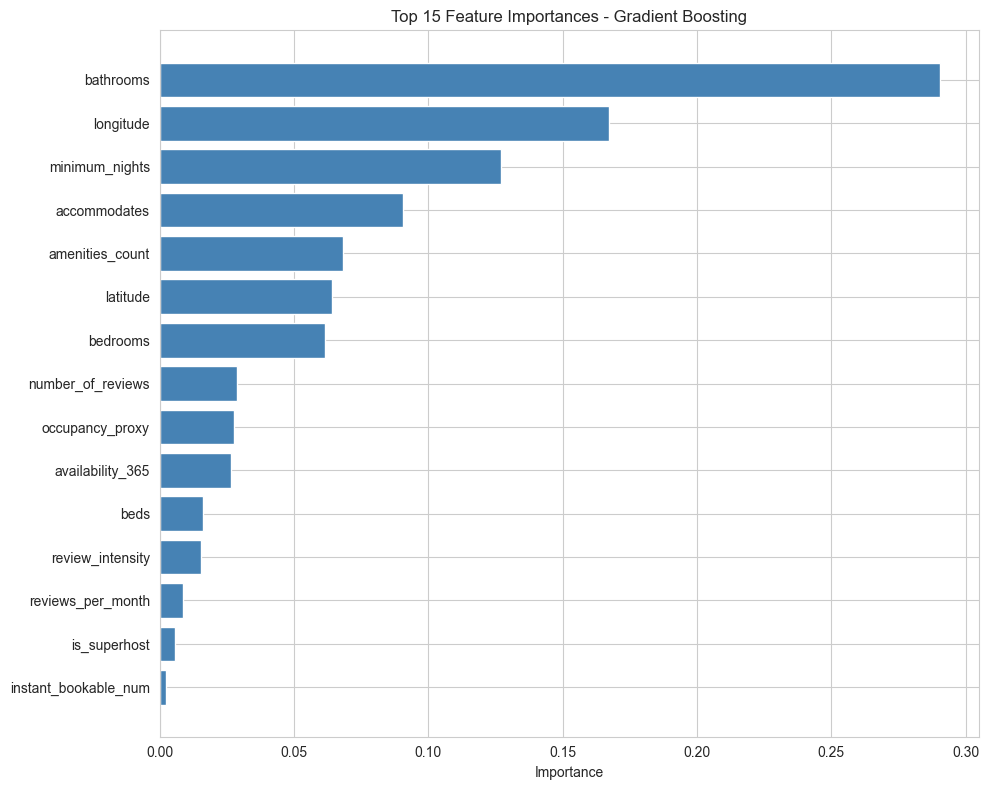


✅ Feature importance saved to 'feature_importance.csv'


In [12]:
print("\n" + "="*80)
print("SECTION 11: FEATURE IMPORTANCE ANALYSIS")
print("="*80)

if hasattr(best_model, 'feature_importances_'):
    # Get feature importance
    feature_imp = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 15 Most Important Features:")
    print(feature_imp.head(15).to_string(index=False))
    
    # Visualize
    plt.figure(figsize=(10, 8))
    plt.barh(range(min(15, len(feature_imp))), 
            feature_imp['Importance'].head(15),
            color='steelblue')
    plt.yticks(range(min(15, len(feature_imp))), 
              feature_imp['Feature'].head(15))
    plt.xlabel('Importance')
    plt.title(f'Top 15 Feature Importances - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Save to CSV
    feature_imp.to_csv('feature_importance.csv', index=False)
    print("\n✅ Feature importance saved to 'feature_importance.csv'")
else:
    print(f"\n⚠️  {best_model_name} does not provide feature importances")
    print("   (Linear models use coefficients instead)")

# SECTION 12: BUSINESS IMPACT ANALYSIS


SECTION 12: BUSINESS IMPACT ANALYSIS

💰 Pricing Analysis:
   Average Current Price: $232.19
   Average Predicted Price: $237.46
   Average Difference: $5.27 (+2.27%)

📊 Revenue Impact Simulation:
   Portfolio Size: 388 listings
   Assumed Occupancy: 70%
   Current Annual Revenue: $23,018,250.50
   Optimized Annual Revenue: $23,540,523.13
   Potential Increase: $522,272.63 (+2.27%)

🎯 Property Segments:
   Underpriced: 173 properties (44.6%)
      → Average increase opportunity: $74.76/night
   Optimally Priced: 109 properties (28.1%)
   Overpriced: 106 properties (27.3%)
      → Average decrease needed: $103.33/night


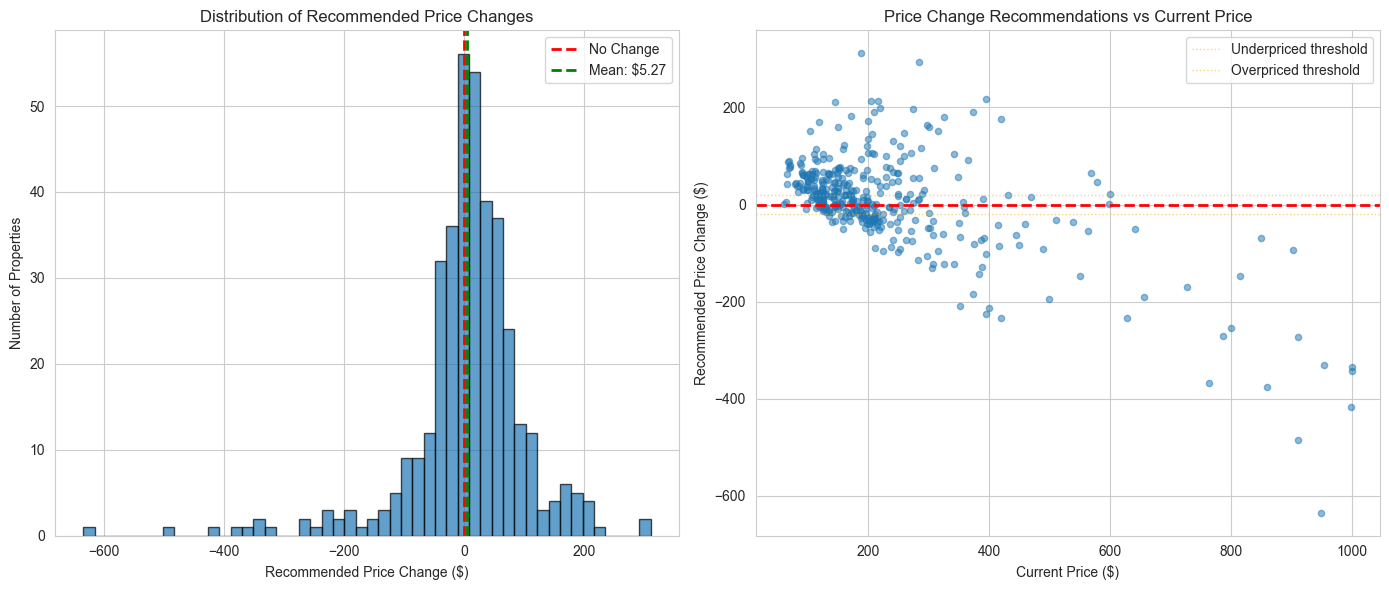


✅ Business impact visualization saved!


In [13]:
print("\n" + "="*80)
print("SECTION 12: BUSINESS IMPACT ANALYSIS")
print("="*80)

# Calculate price differences
price_diff = y_pred_best - y_test.values

# Overall statistics
avg_current = y_test.mean()
avg_predicted = y_pred_best.mean()
price_change = avg_predicted - avg_current
pct_change = (price_change / avg_current) * 100

print(f"\n💰 Pricing Analysis:")
print(f"   Average Current Price: ${avg_current:.2f}")
print(f"   Average Predicted Price: ${avg_predicted:.2f}")
print(f"   Average Difference: ${price_change:.2f} ({pct_change:+.2f}%)")

# Simulate revenue impact
num_listings = len(y_test)
occupancy_rate = 0.70  # Conservative assumption
days_per_year = 365

current_revenue = avg_current * days_per_year * occupancy_rate * num_listings
predicted_revenue = avg_predicted * days_per_year * occupancy_rate * num_listings
revenue_increase = predicted_revenue - current_revenue

print(f"\n📊 Revenue Impact Simulation:")
print(f"   Portfolio Size: {num_listings} listings")
print(f"   Assumed Occupancy: {occupancy_rate:.0%}")
print(f"   Current Annual Revenue: ${current_revenue:,.2f}")
print(f"   Optimized Annual Revenue: ${predicted_revenue:,.2f}")
print(f"   Potential Increase: ${revenue_increase:,.2f} ({100*revenue_increase/current_revenue:+.2f}%)")

# Identify underpriced properties
underpriced = price_diff > 20  # More than $20 underpriced
overpriced = price_diff < -20  # More than $20 overpriced
optimal = ~(underpriced | overpriced)

print(f"\n🎯 Property Segments:")
print(f"   Underpriced: {underpriced.sum()} properties ({100*underpriced.mean():.1f}%)")
print(f"      → Average increase opportunity: ${price_diff[underpriced].mean():.2f}/night")
print(f"   Optimally Priced: {optimal.sum()} properties ({100*optimal.mean():.1f}%)")
print(f"   Overpriced: {overpriced.sum()} properties ({100*overpriced.mean():.1f}%)")
print(f"      → Average decrease needed: ${abs(price_diff[overpriced].mean()):.2f}/night")

# Visualize price changes
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Distribution of price changes
axes[0].hist(price_diff, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='No Change')
axes[0].axvline(price_diff.mean(), color='green', linestyle='--', 
                linewidth=2, label=f'Mean: ${price_diff.mean():.2f}')
axes[0].set_xlabel('Recommended Price Change ($)')
axes[0].set_ylabel('Number of Properties')
axes[0].set_title('Distribution of Recommended Price Changes')
axes[0].legend()

# Price changes vs current price
axes[1].scatter(y_test, price_diff, alpha=0.5, s=20)
axes[1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1].axhline(20, color='orange', linestyle=':', linewidth=1, alpha=0.5, label='Underpriced threshold')
axes[1].axhline(-20, color='orange', linestyle=':', linewidth=1, alpha=0.5, label='Overpriced threshold')
axes[1].set_xlabel('Current Price ($)')
axes[1].set_ylabel('Recommended Price Change ($)')
axes[1].set_title('Price Change Recommendations vs Current Price')
axes[1].legend()

plt.tight_layout()
plt.savefig('business_impact.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Business impact visualization saved!")

# SECTION 13: EXPORT KEY STATISTICS FOR REPORT

In [14]:
print("\n" + "="*80)
print("SECTION 13: EXPORT STATISTICS FOR REPORT")
print("="*80)

# Compile all key statistics into a dictionary
key_stats = {
    'Data Statistics': {
        'Original Dataset Size': len(df),
        'After Filtering': len(df_clean),
        'Test Set Size': len(X_test),
        'Number of Features': len(feature_columns),
        'Target Neighborhoods': ', '.join(TARGET_NEIGHBORHOODS)
    },
    'Price Statistics': {
        'Mean Price': f"${df_clean['price'].mean():.2f}",
        'Median Price': f"${df_clean['price'].median():.2f}",
        'Std Dev': f"${df_clean['price'].std():.2f}",
        'Min Price': f"${df_clean['price'].min():.2f}",
        'Max Price': f"${df_clean['price'].max():.2f}"
    },
    'Best Model Performance': {
        'Model Name': best_model_name,
        'RMSE': f"${results_df.iloc[0]['RMSE']:.2f}",
        'MAE': f"${results_df.iloc[0]['MAE']:.2f}",
        'R²': f"{results_df.iloc[0]['R²']:.4f}",
        'MAPE': f"{results_df.iloc[0]['MAPE']:.2f}%"
    },
    'Business Impact': {
        'Current Avg Price': f"${avg_current:.2f}",
        'Predicted Avg Price': f"${avg_predicted:.2f}",
        'Price Change': f"${price_change:.2f} ({pct_change:+.2f}%)",
        'Portfolio Size': num_listings,
        'Assumed Occupancy': f"{occupancy_rate:.0%}",
        'Current Annual Revenue': f"${current_revenue:,.2f}",
        'Optimized Annual Revenue': f"${predicted_revenue:,.2f}",
        'Revenue Increase': f"${revenue_increase:,.2f} ({100*revenue_increase/current_revenue:+.2f}%)",
        'Underpriced Properties': f"{underpriced.sum()} ({100*underpriced.mean():.1f}%)",
        'Overpriced Properties': f"{overpriced.sum()} ({100*overpriced.mean():.1f}%)"
    }
}

# Print formatted statistics
print("\n📊 KEY STATISTICS FOR YOUR REPORT:")
print("="*80)
for category, stats in key_stats.items():
    print(f"\n{category}:")
    for key, value in stats.items():
        print(f"   {key}: {value}")

# Save to file
with open('key_statistics.txt', 'w') as f:
    f.write("AIRBNB PRICING OPTIMIZATION - KEY STATISTICS\n")
    f.write("="*80 + "\n\n")
    for category, stats in key_stats.items():
        f.write(f"{category}:\n")
        for key, value in stats.items():
            f.write(f"   {key}: {value}\n")
        f.write("\n")

print("\n✅ Statistics saved to 'key_statistics.txt'")

# Also save as DataFrame for easy access
stats_df = pd.DataFrame([
    {'Category': cat, 'Metric': key, 'Value': value}
    for cat, stats in key_stats.items()
    for key, value in stats.items()
])
stats_df.to_csv('key_statistics.csv', index=False)
print("✅ Statistics saved to 'key_statistics.csv'")


SECTION 13: EXPORT STATISTICS FOR REPORT

📊 KEY STATISTICS FOR YOUR REPORT:

Data Statistics:
   Original Dataset Size: 36111
   After Filtering: 1937
   Test Set Size: 388
   Number of Features: 15
   Target Neighborhoods: Williamsburg, Upper East Side, Astoria, Bedford-Stuyvesant, Hell's Kitchen, Harlem, Bushwick, Crown Heights

Price Statistics:
   Mean Price: $227.43
   Median Price: $180.00
   Std Dev: $151.90
   Min Price: $53.00
   Max Price: $1000.00

Best Model Performance:
   Model Name: Gradient Boosting
   RMSE: $100.14
   MAE: $64.20
   R²: 0.6514
   MAPE: 29.68%

Business Impact:
   Current Avg Price: $232.19
   Predicted Avg Price: $237.46
   Price Change: $5.27 (+2.27%)
   Portfolio Size: 388
   Assumed Occupancy: 70%
   Current Annual Revenue: $23,018,250.50
   Optimized Annual Revenue: $23,540,523.13
   Revenue Increase: $522,272.63 (+2.27%)
   Underpriced Properties: 173 (44.6%)
   Overpriced Properties: 106 (27.3%)

✅ Statistics saved to 'key_statistics.txt'
✅ Stat

# SECTION 14: NEIGHBORHOOD-LEVEL INSIGHTS


SECTION 14: NEIGHBORHOOD-LEVEL INSIGHTS

📍 Insights by Neighborhood:
                    count  current_avg  current_median  predicted_avg  predicted_median  change_avg  change_median
neighborhood                                                                                                      
Astoria                11       217.18           210.0         258.30            195.20       41.12          26.97
Bedford-Stuyvesant     86       194.99           178.5         199.55            172.04        4.56           6.56
Bushwick               26       186.50           161.5         210.16            170.64       23.66          21.88
Crown Heights          51       240.94           171.0         256.70            206.45       15.76          26.87
Harlem                 56       213.77           189.0         223.32            185.41        9.55          10.83
Hell's Kitchen         52       278.29           177.5         284.18            242.26        5.90           5.04
Upper East

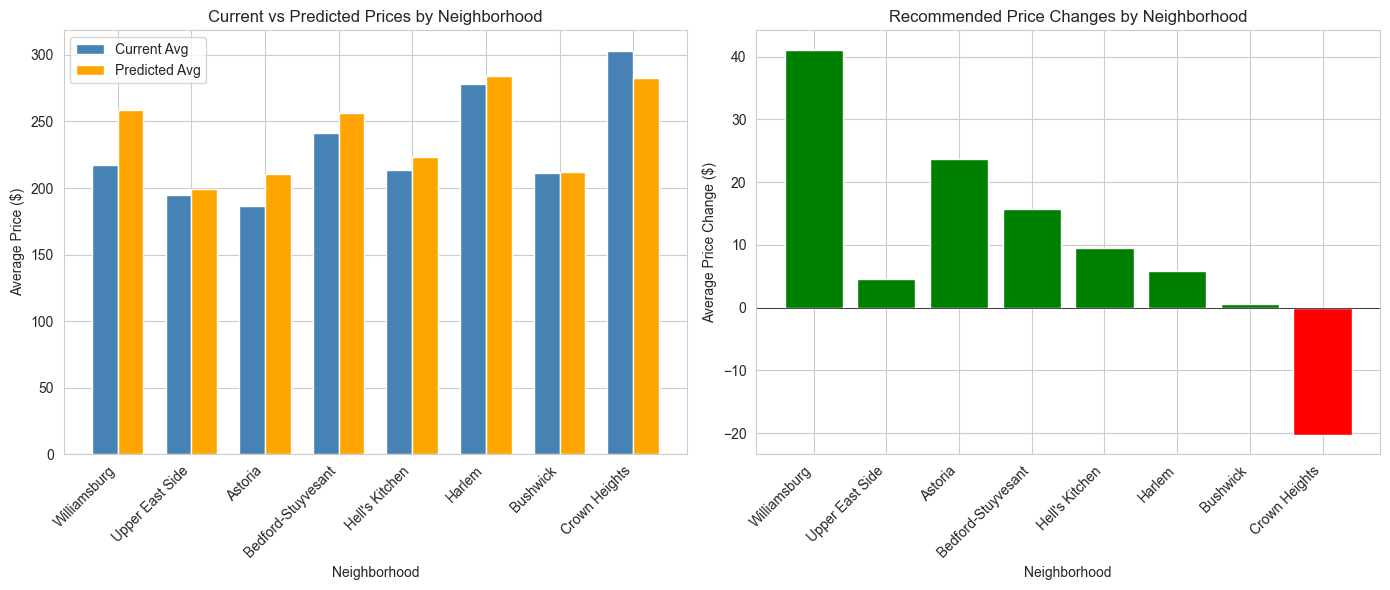


✅ Neighborhood insights saved to 'neighborhood_insights.csv'


In [15]:
print("\n" + "="*80)
print("SECTION 14: NEIGHBORHOOD-LEVEL INSIGHTS")
print("="*80)

# Create a dataframe with predictions
results_by_neighborhood = pd.DataFrame({
    'neighborhood': df_clean.loc[y_test.index, neighborhood_col].values,
    'actual_price': y_test.values,
    'predicted_price': y_pred_best,
    'price_change': price_diff
})

# Group by neighborhood
neighborhood_insights = results_by_neighborhood.groupby('neighborhood').agg({
    'actual_price': ['count', 'mean', 'median'],
    'predicted_price': ['mean', 'median'],
    'price_change': ['mean', 'median']
}).round(2)

neighborhood_insights.columns = ['count', 'current_avg', 'current_median',
                                 'predicted_avg', 'predicted_median',
                                 'change_avg', 'change_median']

print("\n📍 Insights by Neighborhood:")
print(neighborhood_insights)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Current vs Predicted by Neighborhood
x = np.arange(len(TARGET_NEIGHBORHOODS))
width = 0.35

axes[0].bar(x - width/2, neighborhood_insights['current_avg'], width, 
           label='Current Avg', color='steelblue')
axes[0].bar(x + width/2, neighborhood_insights['predicted_avg'], width,
           label='Predicted Avg', color='orange')
axes[0].set_xlabel('Neighborhood')
axes[0].set_ylabel('Average Price ($)')
axes[0].set_title('Current vs Predicted Prices by Neighborhood')
axes[0].set_xticks(x)
axes[0].set_xticklabels(TARGET_NEIGHBORHOODS, rotation=45, ha='right')
axes[0].legend()

# Average price change by neighborhood
colors = ['green' if x > 0 else 'red' for x in neighborhood_insights['change_avg']]
axes[1].bar(TARGET_NEIGHBORHOODS, neighborhood_insights['change_avg'], color=colors)
axes[1].set_xlabel('Neighborhood')
axes[1].set_ylabel('Average Price Change ($)')
axes[1].set_title('Recommended Price Changes by Neighborhood')
axes[1].axhline(0, color='black', linestyle='-', linewidth=0.5)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig('neighborhood_insights.png', dpi=300, bbox_inches='tight')
plt.show()

# Save insights
neighborhood_insights.to_csv('neighborhood_insights.csv')
print("\n✅ Neighborhood insights saved to 'neighborhood_insights.csv'")


# SECTION 15: GENERATE SAMPLE RECOMMENDATIONS|

In [16]:
print("\n" + "="*80)
print("SECTION 15: SAMPLE PRICING RECOMMENDATIONS")
print("="*80)

# Create recommendations dataframe
recommendations = pd.DataFrame({
    'listing_id': df_clean.loc[y_test.index, 'id'].values,
    'name': df_clean.loc[y_test.index, 'name'].values,
    'neighborhood': df_clean.loc[y_test.index, neighborhood_col].values,
    'current_price': y_test.values,
    'recommended_price': y_pred_best,
    'price_change': price_diff,
    'pct_change': (price_diff / y_test.values * 100),
    'accommodates': df_clean.loc[y_test.index, 'accommodates'].values,
    'bedrooms': df_clean.loc[y_test.index, 'bedrooms'].values,
    'number_of_reviews': df_clean.loc[y_test.index, 'number_of_reviews'].values
})

recommendations = recommendations.round(2)

print("\n🔥 Top 10 UNDERPRICED Properties (Biggest Opportunities):")
top_underpriced = recommendations.nlargest(10, 'price_change')
print(top_underpriced[['name', 'neighborhood', 'current_price', 
                       'recommended_price', 'price_change', 'pct_change']].to_string(index=False))

print("\n⚠️  Top 10 OVERPRICED Properties (Need Price Reduction):")
top_overpriced = recommendations.nsmallest(10, 'price_change')
print(top_overpriced[['name', 'neighborhood', 'current_price',
                      'recommended_price', 'price_change', 'pct_change']].to_string(index=False))

# Save all recommendations
recommendations.to_csv('pricing_recommendations.csv', index=False)
print(f"\n✅ Full recommendations saved to 'pricing_recommendations.csv' ({len(recommendations)} properties)")


SECTION 15: SAMPLE PRICING RECOMMENDATIONS

🔥 Top 10 UNDERPRICED Properties (Biggest Opportunities):
                                              name       neighborhood  current_price  recommended_price  price_change  pct_change
   Duplex Apt. in a Brownstone/Morningside Heights             Harlem          189.0             500.45        311.45      164.79
           Brooklyn Retreat for Groups | Sleeps 10           Bushwick          285.0             578.63        293.63      103.03
   Williamsburg Townhouse/1800ft²/Backyard  Garden       Williamsburg          395.0             612.76        217.76       55.13
**FULL FLOOR - 3 BEDRMS, Times Sq/Restaurant Row**     Hell's Kitchen          217.0             430.39        213.39       98.33
       2 Bed + 2 Bath with City Views & Onsite Gym     Hell's Kitchen          204.0             416.84        212.84      104.33
  Modern Apt with 2 private terraces for 360 views       Williamsburg          145.0             355.84        210.84 

# SECTION 16: ERROR ANALYSIS


SECTION 16: ERROR ANALYSIS


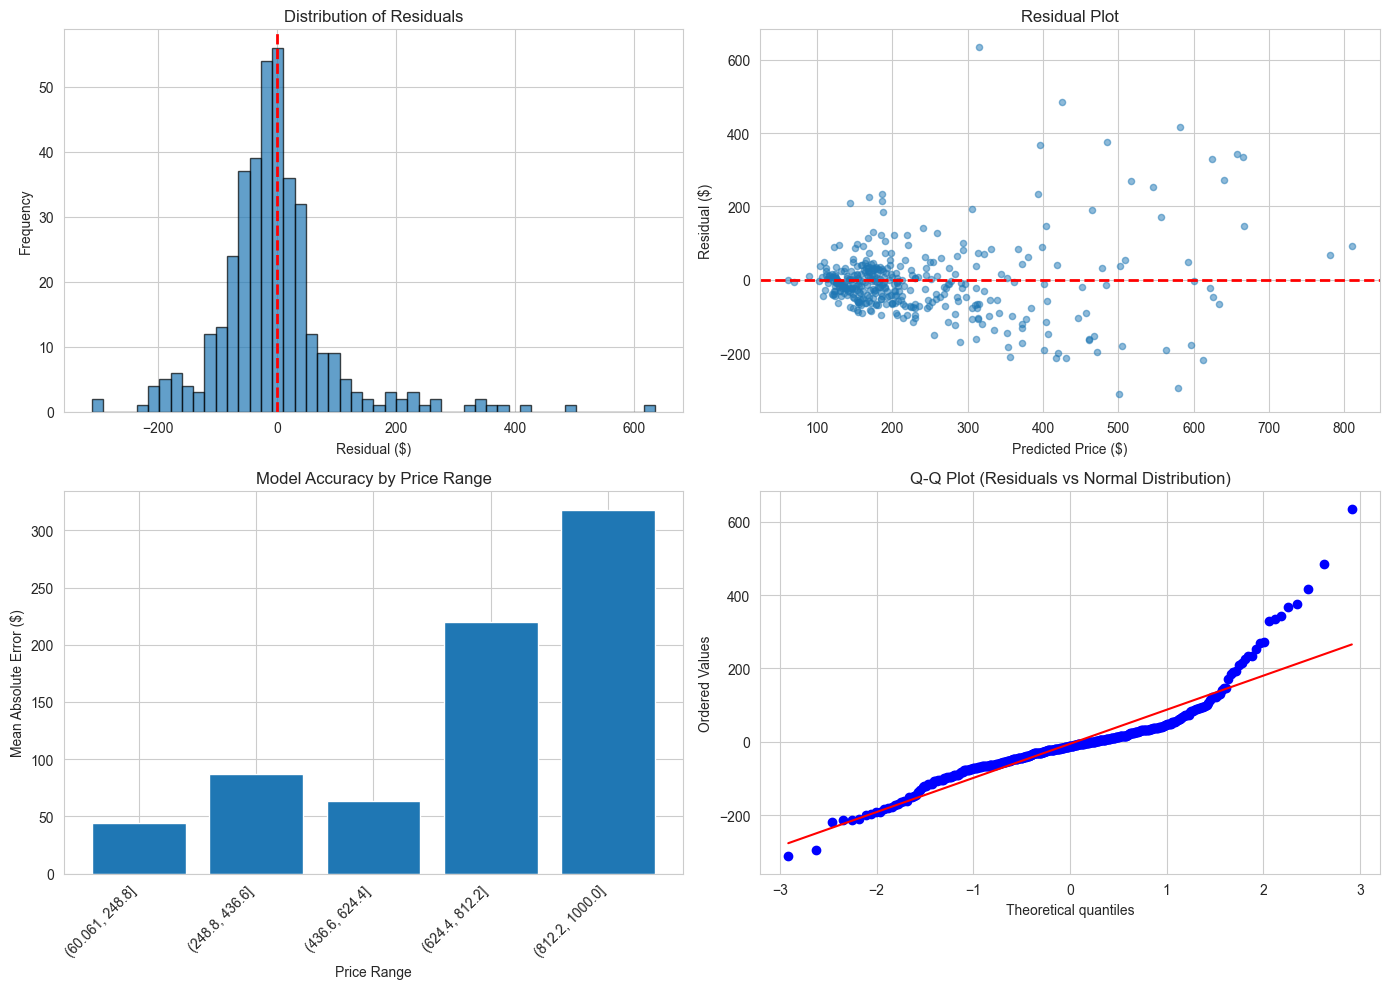


📉 Residual Statistics:
   Mean Residual: $-5.27 (should be close to 0)
   Std Dev: $100.00
   Min Error: $-311.45 (underestimated)
   Max Error: $635.07 (overestimated)

🚨 Properties with Largest Prediction Errors:
                                              name   neighborhood  actual  predicted      error
                              Bohemian Garden Loft   Williamsburg   950.0 314.930708 635.069292
Chic, Bohemian 3BD/2BA + Roof deck in Williamsburg   Williamsburg   911.0 425.780685 485.219315
     Lavishly styled 2 bedroom High-Rise Apartment Hell's Kitchen   999.0 582.549896 416.450104
 Beautiful Williamsburg Townhouse 4 bed / 2.5 bath   Williamsburg   860.0 484.590754 375.409246
 Pacific by Rove Travel | Duplex w/Deck & Backyard  Crown Heights   764.0 395.459822 368.540178


In [17]:
print("\n" + "="*80)
print("SECTION 16: ERROR ANALYSIS")
print("="*80)

# Calculate residuals
residuals = y_test.values - y_pred_best

# Residual analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Residual distribution
axes[0, 0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Residual ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Residuals')

# Residuals vs Predicted
axes[0, 1].scatter(y_pred_best, residuals, alpha=0.5, s=20)
axes[0, 1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Predicted Price ($)')
axes[0, 1].set_ylabel('Residual ($)')
axes[0, 1].set_title('Residual Plot')

# Absolute error by price range
price_bins = pd.cut(y_test, bins=5)
abs_error_by_bin = pd.DataFrame({
    'price_range': price_bins,
    'abs_error': np.abs(residuals)
}).groupby('price_range')['abs_error'].mean()

axes[1, 0].bar(range(len(abs_error_by_bin)), abs_error_by_bin.values)
axes[1, 0].set_xticks(range(len(abs_error_by_bin)))
axes[1, 0].set_xticklabels([str(x) for x in abs_error_by_bin.index], rotation=45, ha='right')
axes[1, 0].set_xlabel('Price Range')
axes[1, 0].set_ylabel('Mean Absolute Error ($)')
axes[1, 0].set_title('Model Accuracy by Price Range')

# Q-Q plot for normality check
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Residuals vs Normal Distribution)')

plt.tight_layout()
plt.savefig('error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📉 Residual Statistics:")
print(f"   Mean Residual: ${residuals.mean():.2f} (should be close to 0)")
print(f"   Std Dev: ${residuals.std():.2f}")
print(f"   Min Error: ${residuals.min():.2f} (underestimated)")
print(f"   Max Error: ${residuals.max():.2f} (overestimated)")

# Identify properties with largest errors
large_errors = pd.DataFrame({
    'listing_id': df_clean.loc[y_test.index, 'id'].values,
    'name': df_clean.loc[y_test.index, 'name'].values,
    'neighborhood': df_clean.loc[y_test.index, neighborhood_col].values,
    'actual': y_test.values,
    'predicted': y_pred_best,
    'error': residuals,
    'abs_error': np.abs(residuals)
})

print(f"\n🚨 Properties with Largest Prediction Errors:")
worst_predictions = large_errors.nlargest(5, 'abs_error')
print(worst_predictions[['name', 'neighborhood', 'actual', 'predicted', 'error']].to_string(index=False))


# SECTION 17: FINAL SUMMARY

In [18]:
print("\n" + "="*80)
print("FINAL PROJECT SUMMARY")
print("="*80)

print(f"""
✅ PROJECT COMPLETED SUCCESSFULLY!

📊 Dataset:
   - Original: {len(df):,} NYC Airbnb listings
   - Filtered: {len(df_clean):,} listings in {len(TARGET_NEIGHBORHOODS)} neighborhoods
   - Test set: {len(X_test):,} properties

🏆 Best Model: {best_model_name}
   - RMSE: ${results_df.iloc[0]['RMSE']:.2f}
   - R²: {results_df.iloc[0]['R²']:.4f}
   - MAPE: {results_df.iloc[0]['MAPE']:.2f}%

💰 Business Impact:
   - Potential revenue increase: ${revenue_increase:,.2f} ({100*revenue_increase/current_revenue:.1f}%)
   - Underpriced properties: {underpriced.sum()} ({100*underpriced.mean():.1f}%)
   - Average opportunity: ${price_diff[underpriced].mean():.2f}/night per underpriced property

📁 Generated Files:
   1. model_results.csv - Model performance comparison
   2. feature_importance.csv - Feature importance rankings
   3. key_statistics.csv/.txt - All statistics for report
   4. neighborhood_insights.csv - Neighborhood-level analysis
   5. pricing_recommendations.csv - Property-specific recommendations
   
🎨 Generated Visualizations:
   1. neighborhood_overview.png - Initial data exploration
   2. price_distribution.png - Price analysis
   3. price_by_neighborhood_box.png - Price by location
   4. correlation_matrix.png - Feature correlations
   5. scatter_plots.png - Key relationships
   6. model_comparison.png - Model performance
   7. actual_vs_predicted.png - Prediction accuracy
   8. feature_importance.png - Top features
   9. business_impact.png - Revenue opportunity
   10. neighborhood_insights.png - Neighborhood analysis
   11. error_analysis.png - Model diagnostics

📝 Next Steps:
   1. Review all generated visualizations
   2. Use key_statistics.txt to fill in your report template
   3. Copy best charts into your presentation
   4. Prepare your business recommendations
   5. Practice your presentation!

🎯 Recommendations for Presentation:
   - Lead with business impact (${revenue_increase:,.2f} opportunity)
   - Show neighborhood diversity in your data
   - Highlight {best_model_name} performance
   - Explain top 3 features that drive pricing
   - Present phased implementation plan

Good luck with your project! 🚀
""")

# Save cleaned dataset for future use
df_clean.to_csv('cleaned_dataset.csv', index=False)
print("💾 Cleaned dataset saved to 'cleaned_dataset.csv'")

print("\n" + "="*80)
print("🎉 ALL ANALYSIS COMPLETE! 🎉")
print("="*80)


FINAL PROJECT SUMMARY

✅ PROJECT COMPLETED SUCCESSFULLY!

📊 Dataset:
   - Original: 36,111 NYC Airbnb listings
   - Filtered: 1,937 listings in 8 neighborhoods
   - Test set: 388 properties

🏆 Best Model: Gradient Boosting
   - RMSE: $100.14
   - R²: 0.6514
   - MAPE: 29.68%

💰 Business Impact:
   - Potential revenue increase: $522,272.63 (2.3%)
   - Underpriced properties: 173 (44.6%)
   - Average opportunity: $74.76/night per underpriced property

📁 Generated Files:
   1. model_results.csv - Model performance comparison
   2. feature_importance.csv - Feature importance rankings
   3. key_statistics.csv/.txt - All statistics for report
   4. neighborhood_insights.csv - Neighborhood-level analysis
   5. pricing_recommendations.csv - Property-specific recommendations

🎨 Generated Visualizations:
   1. neighborhood_overview.png - Initial data exploration
   2. price_distribution.png - Price analysis
   3. price_by_neighborhood_box.png - Price by location
   4. correlation_matrix.png - F